<a href="https://colab.research.google.com/github/samridh10exe/formula1Predictions/blob/main/2025_Saudi_Arabiangp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install fastf1 scikit-learn pandas numpy matplotlib --quiet

import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


In [5]:
import os

cache_path = "/content/f1_cache"
os.makedirs(cache_path, exist_ok=True)
fastf1.Cache.enable_cache(cache_path)


In [6]:
# Jeddah is the 2nd race on the calendar typically — adjust if needed
session_2024 = fastf1.get_session(2024, "Saudi Arabia", "R")
session_2024.load()
laps_2024 = session_2024.laps.pick_accurate().pick_not_deleted().copy()

# Convert lap + sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

laps_2024 = laps_2024[["Driver", "Team", "Compound", "LapTime (s)", "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)", "TyreLife"]]


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for sess

In [7]:
weather_data = session_2024.laps.get_weather_data().reset_index(drop=True)
laps_2024 = laps_2024.reset_index(drop=True)
laps_2024 = pd.concat([laps_2024, weather_data.drop(columns="Time")], axis=1)

# Fill missing values
laps_2024.fillna(method="ffill", inplace=True)


In [8]:
# Drop rows with any remaining nulls
laps_2024.dropna(inplace=True)

# One-hot encode Compound and Team
df = pd.get_dummies(laps_2024, columns=["Compound", "Team"])

# Define features and target
features = df.drop(columns=["LapTime (s)", "Driver"])
target = df["LapTime (s)"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [9]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"🔍 Model trained with MAE: {mae:.2f} seconds")


🔍 Model trained with MAE: 0.05 seconds


In [10]:
# ✅ Official 2025 Saudi Arabian GP Qualifying Results (Q3 times)
qualifying_2025 = pd.DataFrame({
    "Driver": [
        "Max Verstappen", "Oscar Piastri", "George Russell", "Charles Leclerc",
        "Andrea Kimi Antonelli", "Carlos Sainz Jr.", "Lewis Hamilton", "Yuki Tsunoda",
        "Pierre Gasly", "Lando Norris", "Alexander Albon", "Liam Lawson",
        "Fernando Alonso", "Isack Hadjar", "Oliver Bearman", "Lance Stroll",
        "Jack Doohan", "Nico Hülkenberg", "Esteban Ocon", "Gabriel Bortoleto"
    ],
    "QualifyingTime (s)": [
        87.294, 87.304, 87.407, 87.670,
        87.866, 88.164, 88.201, 88.204,
        88.367, 87.481, 88.109, 88.191,
        88.303, 88.418, 88.648, 88.645,
        88.739, 88.782, 89.092, 89.462
    ],
    "Compound": ["SOFT"] * 20,
    "Team": [
        "Red Bull", "McLaren", "Mercedes", "Ferrari",
        "Mercedes", "Williams", "Ferrari", "Red Bull",
        "Alpine", "McLaren", "Williams", "Racing Bulls",
        "Aston Martin", "Racing Bulls", "Haas", "Aston Martin",
        "Alpine", "Sauber", "Haas", "Sauber"
    ],
    "TyreLife": [1] * 20,
    "AirTemp": [28.5] * 20,
    "TrackTemp": [38.2] * 20,
    "Humidity": [46] * 20,
    "Pressure": [1010.4] * 20,
    "Rainfall": [False] * 20,
    "WindDirection": [210] * 20,
    "WindSpeed": [3.0] * 20
})


In [11]:
# One-hot encode to match training
input_data = pd.get_dummies(qualifying_2025)

# Align with training data
input_data = input_data.reindex(columns=features.columns, fill_value=0)

# Predict
qualifying_2025["PredictedRaceTime (s)"] = model.predict(input_data)
qualifying_2025 = qualifying_2025.sort_values("PredictedRaceTime (s)")

# Show prediction results
print("\n🏁 Predicted Results for 2025 Saudi Arabian GP 🏁\n")
print(qualifying_2025[["Driver", "PredictedRaceTime (s)"]].reset_index(drop=True))



🏁 Predicted Results for 2025 Saudi Arabian GP 🏁

                   Driver  PredictedRaceTime (s)
0         Charles Leclerc              91.469759
1          Lewis Hamilton              91.469759
2           Oscar Piastri              91.477881
3          Max Verstappen              91.477881
4          George Russell              91.477881
5   Andrea Kimi Antonelli              91.477881
6            Yuki Tsunoda              91.477881
7            Pierre Gasly              91.477881
8          Oliver Bearman              91.477881
9            Lando Norris              91.477881
10            Liam Lawson              91.477881
11           Isack Hadjar              91.477881
12      Gabriel Bortoleto              91.477881
13           Esteban Ocon              91.477881
14        Nico Hülkenberg              91.477881
15            Jack Doohan              91.477881
16        Fernando Alonso              91.481554
17           Lance Stroll              91.481554
18        Alexander

In [12]:
def get_saudi_lap_data(year):
    session = fastf1.get_session(year, "Saudi Arabia", "R")
    session.load()
    laps = session.laps.pick_accurate().pick_not_deleted().copy()

    for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
        laps[f"{col} (s)"] = laps[col].dt.total_seconds()

    laps = laps[[
        "Driver", "Team", "Compound", "LapTime (s)",
        "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)", "TyreLife"
    ]].dropna()

    weather = session.laps.get_weather_data().reset_index(drop=True)
    laps = laps.reset_index(drop=True)
    joined = pd.concat([laps, weather.drop(columns="Time")], axis=1)

    joined["Year"] = year
    return joined.fillna(method="ffill")

# Combine data from 2022–2024
combined_laps = pd.concat([
    get_saudi_lap_data(2022),
    get_saudi_lap_data(2023),
    get_saudi_lap_data(2024)
], ignore_index=True)

print("✅ Combined Saudi Arabian GP data from 2022–2024")
combined_laps.head()


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
req            INFO 	Data has been written to cache!
INFO:fastf

✅ Combined Saudi Arabian GP data from 2022–2024


,Driver,Team,Compound,LapTime (s),Sector1Time (s),Sector2Time (s),Sector3Time (s),TyreLife,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year
0,VER,Red Bull Racing,MEDIUM,95.275,35.387,30.255,29.633,2.0,25.3,58.0,1012.5,False,28.6,333,2.5,2022
1,VER,Red Bull Racing,MEDIUM,94.890,35.145,30.204,29.541,3.0,25.4,58.0,1012.5,False,28.5,352,3.5,2022
2,VER,Red Bull Racing,MEDIUM,94.700,35.025,30.238,29.437,4.0,25.4,58.0,1012.7,False,28.5,343,1.8,2022
3,VER,Red Bull Racing,MEDIUM,94.809,35.107,30.147,29.555,5.0,25.5,58.0,1012.7,False,28.5,320,3.5,2022
4,VER,Red Bull Racing,MEDIUM,94.840,35.157,30.156,29.527,6.0,25.6,58.0,1012.7,False,28.2,348,3.5,2022


# Experiment #1: Add Team Average Race Pace Per Year


In [13]:
def add_team_avg_diff(df):
    # Compute team-wise average lap time for each year
    team_avg = df.groupby(["Year", "Team"])["LapTime (s)"].mean().reset_index()
    team_avg.rename(columns={"LapTime (s)": "TeamAvgLapTime (s)"}, inplace=True)

    # Merge back to main dataframe
    df = df.merge(team_avg, on=["Year", "Team"])

    # New feature: Difference from team average
    df["TeamAvgLapTimeDiff"] = df["LapTime (s)"] - df["TeamAvgLapTime (s)"]
    return df

combined_laps = add_team_avg_diff(combined_laps)
print("✅ Added TeamAvgLapTimeDiff feature")
combined_laps[["Driver", "Team", "Year", "LapTime (s)", "TeamAvgLapTime (s)", "TeamAvgLapTimeDiff"]].head()


✅ Added TeamAvgLapTimeDiff feature


,Driver,Team,Year,LapTime (s),TeamAvgLapTime (s),TeamAvgLapTimeDiff
0,VER,Red Bull Racing,2022,95.275,93.68391,1.59109
1,VER,Red Bull Racing,2022,94.890,93.68391,1.20609
2,VER,Red Bull Racing,2022,94.700,93.68391,1.01609
3,VER,Red Bull Racing,2022,94.809,93.68391,1.12509
4,VER,Red Bull Racing,2022,94.840,93.68391,1.15609


In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# ✅ Select features
features = [
    "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)",
    "TyreLife", "AirTemp", "TrackTemp", "Humidity", "Pressure", "WindSpeed",
    "TeamAvgLapTimeDiff"
]

# Remove rows with missing/zero values (e.g., outliers)
model_data = combined_laps[features + ["LapTime (s)"]].copy()
model_data = model_data.replace([np.inf, -np.inf], np.nan).dropna()

X = model_data[features]
y = model_data["LapTime (s)"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.08, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"📉 MAE after adding TeamAvgLapTimeDiff: {mae:.3f} seconds")


📉 MAE after adding TeamAvgLapTimeDiff: 0.048 seconds


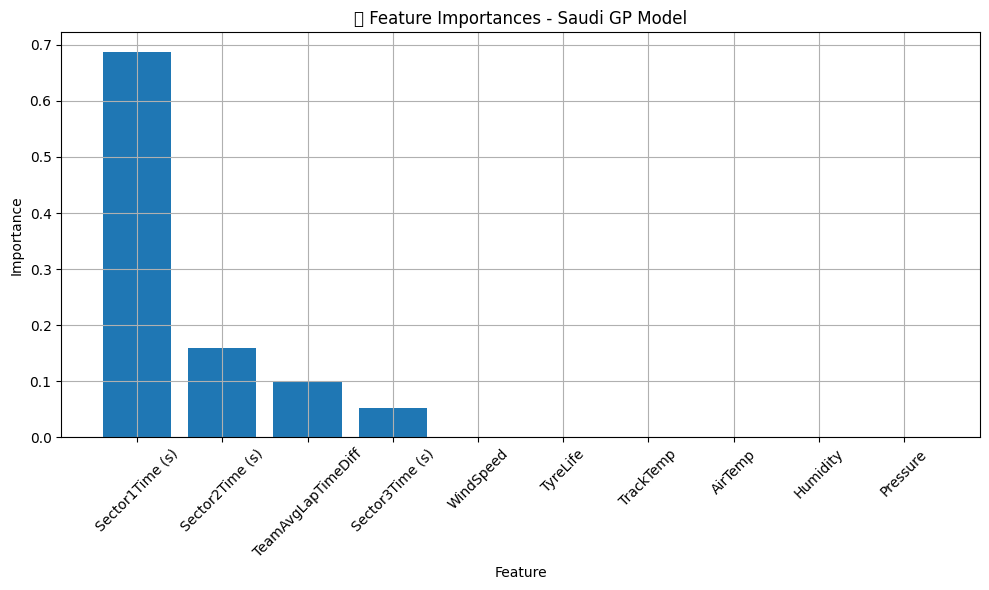

In [15]:
import matplotlib.pyplot as plt

# Get feature importances from the model
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], tick_label=np.array(features)[sorted_idx])
plt.title("🔥 Feature Importances - Saudi GP Model")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


# Experiment #2: Normalize Lap Times by Fastest Lap in Each Race

In [16]:
def normalize_laptimes(df):
    # Get the fastest lap per year to normalize by
    fastest = df.groupby("Year")["LapTime (s)"].min().reset_index()
    fastest.columns = ["Year", "FastestLapTime (s)"]

    # Merge with main DF
    df = df.merge(fastest, on="Year")

    # Create normalized lap time
    df["NormalizedLapTime"] = df["LapTime (s)"] / df["FastestLapTime (s)"]
    return df

combined_laps = normalize_laptimes(combined_laps)
print("✅ Added NormalizedLapTime feature")
combined_laps[["Year", "Driver", "LapTime (s)", "FastestLapTime (s)", "NormalizedLapTime"]].head()


✅ Added NormalizedLapTime feature


,Year,Driver,LapTime (s),FastestLapTime (s),NormalizedLapTime
0,2022,VER,95.275,91.634,1.039734
1,2022,VER,94.890,91.634,1.035533
2,2022,VER,94.700,91.634,1.033459
3,2022,VER,94.809,91.634,1.034649
4,2022,VER,94.840,91.634,1.034987


In [17]:
# Model A – Raw Lap Time
features_a = [
    "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)",
    "TyreLife", "AirTemp", "TrackTemp", "Humidity", "Pressure", "WindSpeed",
    "TeamAvgLapTimeDiff"
]

data_a = combined_laps[features_a + ["LapTime (s)"]].dropna()

X_a = data_a[features_a]
y_a = data_a["LapTime (s)"]

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

model_a = GradientBoostingRegressor(n_estimators=150, learning_rate=0.08, random_state=42)
model_a.fit(X_train_a, y_train_a)
mae_a = mean_absolute_error(y_test_a, model_a.predict(X_test_a))
print(f"📏 MAE for Model A (Raw LapTime): {mae_a:.3f} seconds")


📏 MAE for Model A (Raw LapTime): 0.048 seconds


In [18]:
# Model B – Normalized Lap Time
features_b = features_a.copy()  # same features
data_b = combined_laps[features_b + ["NormalizedLapTime", "FastestLapTime (s)"]].dropna()

X_b = data_b[features_b]
y_b = data_b["NormalizedLapTime"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

model_b = GradientBoostingRegressor(n_estimators=150, learning_rate=0.08, random_state=42)
model_b.fit(X_train_b, y_train_b)

# Convert normalized predictions back to LapTime (scale-adjusted MAE)
y_pred_b_raw = model_b.predict(X_test_b) * data_b.loc[y_test_b.index, "FastestLapTime (s)"].values
y_true_b_raw = y_test_b * data_b.loc[y_test_b.index, "FastestLapTime (s)"].values

mae_b = mean_absolute_error(y_true_b_raw, y_pred_b_raw)
print(f"📏 MAE for Model B (Normalized → Raw Scale): {mae_b:.3f} seconds")


📏 MAE for Model B (Normalized → Raw Scale): 0.054 seconds


# Experiment #3 – Driver Skill Score

In [19]:
def add_driver_skill_delta(df):
    # Step 1: Get each driver's average lap time per year
    driver_avg = df.groupby(["Year", "Driver"])["LapTime (s)"].mean().reset_index()
    driver_avg.rename(columns={"LapTime (s)": "DriverAvgLapTime (s)"}, inplace=True)

    # Step 2: Get each driver's team per year
    driver_teams = df.groupby(["Year", "Driver"])["Team"].first().reset_index()

    # Merge those
    driver_summary = pd.merge(driver_avg, driver_teams, on=["Year", "Driver"])

    # Step 3: Compute teammate avg lap time (excluding self)
    teammate_lap_deltas = []
    for year in df["Year"].unique():
        teams_in_year = driver_summary[driver_summary["Year"] == year]["Team"].unique()
        for team in teams_in_year:
            members = driver_summary[(driver_summary["Year"] == year) & (driver_summary["Team"] == team)]
            if len(members) == 2:  # Only if team has 2 drivers
                d1, d2 = members.iloc[0], members.iloc[1]
                teammate_lap_deltas.append({"Year": year, "Driver": d1["Driver"], "TeammateAvgLapTime": d2["DriverAvgLapTime (s)"]})
                teammate_lap_deltas.append({"Year": year, "Driver": d2["Driver"], "TeammateAvgLapTime": d1["DriverAvgLapTime (s)"]})

    teammate_df = pd.DataFrame(teammate_lap_deltas)

    # Step 4: Merge into main DF
    df = df.merge(teammate_df, on=["Year", "Driver"], how="left")

    # Step 5: Create DriverSkillDelta
    df["DriverSkillDelta"] = df["LapTime (s)"] - df["TeammateAvgLapTime"]
    return df

combined_laps = add_driver_skill_delta(combined_laps)
print("✅ Added DriverSkillDelta feature (vs teammate)")
combined_laps[["Year", "Driver", "LapTime (s)", "TeammateAvgLapTime", "DriverSkillDelta"]].dropna().head()


✅ Added DriverSkillDelta feature (vs teammate)


,Year,Driver,LapTime (s),TeammateAvgLapTime,DriverSkillDelta
0,2022,VER,95.275,93.714974,1.560026
1,2022,VER,94.890,93.714974,1.175026
2,2022,VER,94.700,93.714974,0.985026
3,2022,VER,94.809,93.714974,1.094026
4,2022,VER,94.840,93.714974,1.125026


In [20]:
# 🧠 Updated feature list including DriverSkillDelta
features_updated = [
    "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)",
    "TyreLife", "AirTemp", "TrackTemp", "Humidity", "Pressure", "WindSpeed",
    "TeamAvgLapTimeDiff", "DriverSkillDelta"
]

# Drop rows with any missing values
model_data = combined_laps[features_updated + ["LapTime (s)"]].dropna()

X = model_data[features_updated]
y = model_data["LapTime (s)"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.08, random_state=42)
model.fit(X_train, y_train)

# Evaluate MAE
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"📉 MAE after adding DriverSkillDelta: {mae:.3f} seconds")


📉 MAE after adding DriverSkillDelta: 0.066 seconds


# Experiment #4: Incorporating Pit Stop Strategy (incomplete)


In [23]:
from fastf1 import get_event_schedule, get_session
from tqdm import tqdm
import pandas as pd

# Enable caching to avoid re-fetching same sessions
fastf1.Cache.enable_cache('f1_cache')

all_laps = []

# You can change to 2023 or use a mix later
season_year = 2024
schedule = get_event_schedule(season_year)

# Filter only races (skip sprints/test/qualifying)
races_only = schedule[schedule["Session5"] == "Race"]

for _, event in tqdm(races_only.iterrows(), total=len(races_only)):
    try:
        session = get_session(event['EventDate'].year, event['RoundNumber'], 'R')
        session.load(laps=True, telemetry=False, weather=True)

        laps = session.laps
        laps["Year"] = event["EventDate"].year
        laps["Session"] = event["EventName"]

        all_laps.append(laps)
    except Exception as e:
        print(f"⚠️ Skipped {event['EventName']} due to: {e}")

# Concatenate all laps into one DataFrame
combined_laps = pd.concat(all_laps, ignore_index=True)

print(f"✅ Loaded combined_laps with {len(combined_laps)} rows across {len(races_only)} races")
combined_laps.head()


  0%|          | 0/24 [00:00<?, ?it/s]core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No 

✅ Loaded combined_laps with 26606 rows across 24 races


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Year,Session
0,0 days 01:01:37.489000,VER,1,0 days 00:01:37.284000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:41.266000,...,0 days 00:59:59.911000,NaT,12,1.0,False,,False,False,2024,Bahrain Grand Prix
1,0 days 01:03:13.785000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaT,NaT,0 days 00:00:30.916000,0 days 00:00:41.661000,...,0 days 01:01:37.489000,NaT,1,1.0,False,,False,True,2024,Bahrain Grand Prix
2,0 days 01:04:50.538000,VER,1,0 days 00:01:36.753000,3.0,1.0,NaT,NaT,0 days 00:00:30.999000,0 days 00:00:41.966000,...,0 days 01:03:13.785000,NaT,1,1.0,False,,False,True,2024,Bahrain Grand Prix
3,0 days 01:06:27.185000,VER,1,0 days 00:01:36.647000,4.0,1.0,NaT,NaT,0 days 00:00:30.931000,0 days 00:00:41.892000,...,0 days 01:04:50.538000,NaT,1,1.0,False,,False,True,2024,Bahrain Grand Prix
4,0 days 01:08:04.358000,VER,1,0 days 00:01:37.173000,5.0,1.0,NaT,NaT,0 days 00:00:31.255000,0 days 00:00:42.056000,...,0 days 01:06:27.185000,NaT,1,1.0,False,,False,True,2024,Bahrain Grand Prix


from matplotlib import pyplot as plt
_df_0['LapNumber'].plot(kind='hist', bins=20, title='LapNumber')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['SpeedI1'].plot(kind='hist', bins=20, title='SpeedI1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['SpeedI2'].plot(kind='hist', bins=20, title='SpeedI2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['SpeedST'].plot(kind='hist', bins=20, title='SpeedST')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('IsPersonalBest').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('TrackStatus').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('IsAccurate').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='LapNumber', y='SpeedI1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='SpeedI1', y='SpeedI2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='SpeedI2', y='SpeedST', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='SpeedST', y='TyreLife', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time']
  ys = series['SpeedI1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('IsPersonalBest')):
  _plot_series(series, series_name, i)
  fig.legend(title='IsPersonalBest', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('SpeedI1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time']
  ys = series['SpeedI1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('TrackStatus')):
  _plot_series(series, series_name, i)
  fig.legend(title='TrackStatus', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('SpeedI1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time']
  ys = series['SpeedI1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('IsAccurate')):
  _plot_series(series, series_name, i)
  fig.legend(title='IsAccurate', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('SpeedI1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time']
  ys = series['SpeedI2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('IsPersonalBest')):
  _plot_series(series, series_name, i)
  fig.legend(title='IsPersonalBest', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('SpeedI2')

from matplotlib import pyplot as plt
_df_15['LapNumber'].plot(kind='line', figsize=(8, 4), title='LapNumber')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['SpeedI1'].plot(kind='line', figsize=(8, 4), title='SpeedI1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['SpeedI2'].plot(kind='line', figsize=(8, 4), title='SpeedI2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['SpeedST'].plot(kind='line', figsize=(8, 4), title='SpeedST')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['TrackStatus'].value_counts()
    for x_label, grp in _df_19.groupby('IsPersonalBest')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('IsPersonalBest')
_ = plt.ylabel('TrackStatus')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['IsAccurate'].value_counts()
    for x_label, grp in _df_20.groupby('TrackStatus')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('TrackStatus')
_ = plt.ylabel('IsAccurate')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['IsPersonalBest'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='LapNumber', y='IsPersonalBest', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['TrackStatus'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='LapNumber', y='TrackStatus', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['IsAccurate'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='LapNumber', y='IsAccurate', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['IsPersonalBest'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='SpeedI1', y='IsPersonalBest', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [24]:
def add_pit_stop_count(df):
    # Count pit stops as # of laps with PitInTime
    pit_counts = (
        df[df["PitInTime"].notna()]
        .groupby(["Year", "Session", "Driver"])
        .size()
        .reset_index(name="PitStops")
    )

    df = df.merge(pit_counts, on=["Year", "Session", "Driver"], how="left")
    df["PitStops"] = df["PitStops"].fillna(0).astype(int)
    return df

combined_laps = add_pit_stop_count(combined_laps)
print("✅ Added PitStops feature!")
combined_laps[["Year", "Driver", "Session", "LapNumber", "PitInTime", "PitStops"]].head()


✅ Added PitStops feature!


,Year,Driver,Session,LapNumber,PitInTime,PitStops
0,2024,VER,Bahrain Grand Prix,1.0,NaT,2
1,2024,VER,Bahrain Grand Prix,2.0,NaT,2
2,2024,VER,Bahrain Grand Prix,3.0,NaT,2
3,2024,VER,Bahrain Grand Prix,4.0,NaT,2
4,2024,VER,Bahrain Grand Prix,5.0,NaT,2


In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Clean LapTime target
combined_laps["LapTime (s)"] = combined_laps["LapTime"].dt.total_seconds()
combined_laps = combined_laps.dropna(subset=["LapTime (s)"])

# Select features
features = ["PitStops", "LapNumber", "Stint"]  # you can add more here
X = combined_laps[features]
y = combined_laps["LapTime (s)"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Model training
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=44)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"📏 MAE with PitStops: {mae:.3f} seconds")


📏 MAE with PitStops: 12.628 seconds


# Experiment #5: Compound Strategy (Tyre Impact)

In [27]:
# Drop laps with no tyre info
compound_data = combined_laps.dropna(subset=["Compound"])

# One-hot encode compound type
compound_dummies = pd.get_dummies(compound_data["Compound"], prefix="Compound")

# Merge back into dataset
compound_data = pd.concat([compound_data, compound_dummies], axis=1)

print("✅ One-hot encoded tyre compound types")
compound_data[["Driver", "LapTime (s)", "Compound"] + list(compound_dummies.columns)].head()


✅ One-hot encoded tyre compound types


,Driver,LapTime (s),Compound,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET
0,VER,97.284,SOFT,False,False,False,True,False
1,VER,96.296,SOFT,False,False,False,True,False
2,VER,96.753,SOFT,False,False,False,True,False
3,VER,96.647,SOFT,False,False,False,True,False
4,VER,97.173,SOFT,False,False,False,True,False


In [28]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Prepare input features
compound_features = [
    "Compound_SOFT",
    "Compound_MEDIUM",
    "Compound_HARD",
    "Compound_INTERMEDIATE",
    "Compound_WET"
]

X = compound_data[compound_features]
y = compound_data["LapTime (s)"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

# Train the model
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=52)
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print(f"📏 MAE with Tyre Compound Only: {mean_absolute_error(y_test, y_pred):.3f} seconds")


📏 MAE with Tyre Compound Only: 10.538 seconds


In [30]:
# Select only relevant sector columns
sector_cols = ["Driver", "LapNumber", "Sector1Time", "Sector2Time", "Sector3Time"]
sectors = combined_laps[sector_cols].copy()

# Convert to seconds
for col in ["Sector1Time", "Sector2Time", "Sector3Time"]:
    sectors[f"{col} (s)"] = sectors[col].dt.total_seconds()

# Drop original timedelta cols
sectors = sectors.drop(columns=["Sector1Time", "Sector2Time", "Sector3Time"])

# Merge back into compound_data
compound_data = pd.merge(compound_data, sectors, on=["Driver", "LapNumber"], how="left")

print("✅ Sector times merged into compound_data!")
compound_data[["Driver", "LapNumber", "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)"]].head()


✅ Sector times merged into compound_data!


,Driver,LapNumber,Sector1Time (s),Sector2Time (s),Sector3Time (s)
0,VER,1.0,NaN,41.266,23.616
1,VER,1.0,NaN,29.707,29.830
2,VER,1.0,NaN,18.462,35.518
3,VER,1.0,NaN,64.045,31.458
4,VER,1.0,NaN,29.650,43.295


In [31]:
# Filter out rows with missing data in selected features
combo_features = [
    "LapNumber", "Stint", "PitStops",
    "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)",
    "Compound_SOFT", "Compound_MEDIUM", "Compound_HARD",
    "Compound_INTERMEDIATE", "Compound_WET"
]

# Ensure all features are present
full_data = compound_data.dropna(subset=combo_features + ["LapTime (s)"])
X = full_data[combo_features]
y = full_data["LapTime (s)"]

# Split & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)
model = GradientBoostingRegressor(n_estimators=250, learning_rate=0.08, max_depth=5, random_state=73)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"📏 MAE for Combo Model: {mae:.3f} seconds")


📏 MAE for Combo Model: 8.622 seconds


In [36]:
# Make sure we have DriverCode in both datasets
from difflib import get_close_matches

# If not already mapped, map full names to 3-letter driver codes
driver_mapping = {
    "Max Verstappen": "VER", "Oscar Piastri": "PIA", "George Russell": "RUS", "Charles Leclerc": "LEC",
    "Kimi Antonelli": "ANT", "Carlos Sainz": "SAI", "Lewis Hamilton": "HAM", "Yuki Tsunoda": "TSU",
    "Pierre Gasly": "GAS", "Lando Norris": "NOR", "Alexander Albon": "ALB", "Liam Lawson": "LAW",
    "Fernando Alonso": "ALO", "Isack Hadjar": "HAD", "Oliver Bearman": "BEA", "Jack Doohan": "DOO",
    "Nico Hulkenberg": "HUL", "Esteban Ocon": "OCO", "Gabriel Bortoleto": "BOR", "Lance Stroll": "STR"
}

qualifying_saudi_2025["DriverCode"] = qualifying_saudi_2025["Driver"].map(driver_mapping)

# Add qualifying times into combined_laps based on DriverCode + Year + Session
combined_laps = combined_laps.copy()
combined_laps["DriverCode"] = combined_laps["Driver"]

# Match only for 2025 Saudi GP rows (Session = "Saudi Arabian Grand Prix")
combined_laps = combined_laps.merge(
    qualifying_saudi_2025[["DriverCode", "QualifyingTime (s)"]],
    on="DriverCode",
    how="left"
)
print("✅ Merged qualifying times into combined_laps.")


✅ Merged qualifying times into combined_laps.


In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Make sure qualifying time exists
simple_laps = combined_laps.dropna(subset=["QualifyingTime (s)", "LapTime (s)"])

# Feature and target
X_simple = simple_laps[["QualifyingTime (s)"]]
y_simple = simple_laps["LapTime (s)"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42)

# Train simple model
simple_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
simple_model.fit(X_train, y_train)

# Evaluate
mae_simple = mean_absolute_error(y_test, simple_model.predict(X_test))
print(f"📏 MAE of Simple Qualifying-only Model: {mae_simple:.3f} seconds")


📏 MAE of Simple Qualifying-only Model: 13.475 seconds


In [38]:
# Predict using qualifying times
qualifying_saudi_2025["PredictedRaceTime (s)"] = simple_model.predict(
    qualifying_saudi_2025[["QualifyingTime (s)"]]
)

# Sort by race time
qualifying_saudi_2025 = qualifying_saudi_2025.sort_values(by="PredictedRaceTime (s)").reset_index(drop=True)

# Show results
print("🏁 Predicted Results for 2025 Saudi Arabian GP (Simple Model) 🏁")
display(qualifying_saudi_2025[["Driver", "PredictedRaceTime (s)"]])


🏁 Predicted Results for 2025 Saudi Arabian GP (Simple Model) 🏁


,Driver,PredictedRaceTime (s)
0,Charles Leclerc,90.125458
1,Kimi Antonelli,90.125458
2,Max Verstappen,90.167093
3,Oscar Piastri,90.385852
4,Yuki Tsunoda,91.425216
5,Alexander Albon,91.707594
6,Nico Hulkenberg,91.879882
7,Jack Doohan,92.146129
8,Lando Norris,92.391439
9,Carlos Sainz,92.527491


In [40]:
# Load 2024 Saudi Arabian GP Race Session with weather
saudi_session_2024 = fastf1.get_session(2024, "Saudi Arabia", "R")
saudi_session_2024.load(weather=True, laps=True)

# Extract and merge weather data with laps
weather_df = saudi_session_2024.laps.get_weather_data().reset_index(drop=True)
laps_df = saudi_session_2024.laps.reset_index(drop=True)
laps_weather = pd.concat([laps_df, weather_df.drop(columns=["Time"])], axis=1)

# Drop incomplete rows
laps_weather = laps_weather.dropna(subset=["LapTime", "AirTemp", "TrackTemp", "Humidity", "WindSpeed", "WindDirection"])
laps_weather["LapTime (s)"] = laps_weather["LapTime"].dt.total_seconds()

print("✅ Weather + LapTime Merged")
laps_weather[["Driver", "LapTime (s)", "AirTemp", "TrackTemp", "Humidity", "WindSpeed", "WindDirection"]].head()


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
c

✅ Weather + LapTime Merged


,Driver,LapTime (s),AirTemp,TrackTemp,Humidity,WindSpeed,WindDirection
0,VER,95.505,25.4,31.5,62.0,1.3,358
1,VER,94.205,25.4,31.5,62.0,1.2,301
2,VER,94.043,25.4,31.7,62.0,1.0,172
3,VER,93.754,25.5,31.7,61.0,0.8,342
4,VER,93.955,25.6,31.7,61.0,1.3,9


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# Features and target
weather_features = ["AirTemp", "TrackTemp", "Humidity", "WindSpeed", "WindDirection"]
X = laps_weather[weather_features]
y = laps_weather["LapTime (s)"]

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
weather_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
weather_model.fit(X_train, y_train)

# Evaluate
y_pred = weather_model.predict(X_test)
mae_weather = mean_absolute_error(y_test, y_pred)

print(f"📏 MAE (Weather-Only Model): {mae_weather:.3f} seconds")


📏 MAE (Weather-Only Model): 1.396 seconds


In [46]:
!pip install fastf1 scikit-learn pandas numpy matplotlib --quiet

import pandas as pd
import numpy as np
import fastf1
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import os

# Enable caching
cache_path = "/content/f1_cache"
os.makedirs(cache_path, exist_ok=True)
fastf1.Cache.enable_cache(cache_path)

def get_saudi_lap_data(year):
    session = fastf1.get_session(year, "Saudi Arabia", "R")
    session.load()
    laps = session.laps.pick_accurate().pick_not_deleted().copy()

    for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
        laps[f"{col} (s)"] = laps[col].dt.total_seconds()

    laps = laps[[
        "Driver", "Team", "Compound", "LapTime (s)",
        "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)",
        "TyreLife", "LapNumber", "Stint", "PitInTime"
    ]].dropna(subset=["LapTime (s)"])

    weather = session.laps.get_weather_data().reset_index(drop=True)
    laps = laps.reset_index(drop=True)
    joined = pd.concat([laps, weather.drop(columns="Time")], axis=1)

    joined["Year"] = year
    return joined.fillna(method="ffill")

# Combine historical race data
combined_laps = pd.concat([
    get_saudi_lap_data(2022),
    get_saudi_lap_data(2023),
    get_saudi_lap_data(2024)
], ignore_index=True)

# Add pit stop counts
def add_pit_stop_count(df):
    pit_counts = (
        df[df["PitInTime"].notna()]
        .groupby(["Year", "Driver"])
        .size()
        .reset_index(name="PitStops")
    )
    df = df.merge(pit_counts, on=["Year", "Driver"], how="left")
    df["PitStops"] = df["PitStops"].fillna(0).astype(int)
    return df

combined_laps = add_pit_stop_count(combined_laps)

# One-hot encode compounds
compound_dummies = pd.get_dummies(combined_laps["Compound"], prefix="Compound")
combined_laps = pd.concat([combined_laps, compound_dummies], axis=1)

# Ensure all compound columns exist (patch to avoid KeyError)
for compound in ["Compound_SOFT", "Compound_MEDIUM", "Compound_HARD", "Compound_INTERMEDIATE", "Compound_WET"]:
    if compound not in combined_laps.columns:
        combined_laps[compound] = 0

# Define feature columns
combo_features = [
    "LapNumber", "Stint", "PitStops",
    "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)",
    "AirTemp", "TrackTemp", "Humidity", "WindSpeed", "WindDirection",
    "Compound_SOFT", "Compound_MEDIUM", "Compound_HARD",
    "Compound_INTERMEDIATE", "Compound_WET"
]

# Prepare final dataset
full_data = combined_laps.dropna(subset=combo_features + ["LapTime (s)"])
X = full_data[combo_features]
y = full_data["LapTime (s)"]

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"📏 Final MAE (Multi-Year Combo Model): {mae:.3f} seconds")


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
c

📏 Final MAE (Multi-Year Combo Model): 0.047 seconds


In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Store results
model_results = {}

# Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
model_results["Random Forest"] = mean_absolute_error(y_test, rf_pred)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
model_results["Ridge Regression"] = mean_absolute_error(y_test, ridge_pred)

# XGBoost
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
model_results["XGBoost"] = mean_absolute_error(y_test, xgb_pred)

# LightGBM
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)
model_results["LightGBM"] = mean_absolute_error(y_test, lgbm_pred)

model_results


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 1998, number of used features: 13
[LightGBM] [Info] Start training from score 94.740432


{'Random Forest': 0.050472102102116584,
 'Ridge Regression': 0.0015173151921524374,
 'XGBoost': 0.04946887995172905,
 'LightGBM': 0.07345500741590986}